<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 19 February 2020</div>

# Generating random numbers with arbitrary distribution

<br />
<center>
<img src="https://media3.giphy.com/media/UReWF9frq7Rv7ZIqhy/giphy.gif" width=400 />
</center>

The reason why we use well-known model functions (like the normal or the gamma) in statistics is because of the ***huge*** dimensionality reduction when you use an analytic function: All you need to find out are its parameters, which is usually one, two, or three!

However, with a little bit of coding, you actually *don't need any math at all*, which is what I told you at the beginning of the semester. Either you *know the math*, or you *write the code*! In this notebook, we'll write the code for our model instead of doing the math. This results in a not-so-dramatic dimensionality reduction, but it's still wicked cool.

## 1. Warm-up

Let's generate random variates from a normal distribution, then plot the histogram of the data. You *always* start with a nomral distribution in statistics!

In [1]:
import scipy.stats
import numpy as np
data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5, random_state=123)
hist = np.histogram(data, bins=100)

In [2]:
len(data)

100000

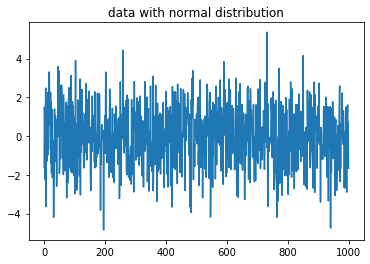

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("data with normal distribution")
plt.plot(data[0:1000], label='data')
plt.show()

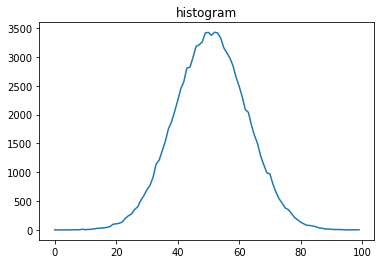

In [5]:
plt.title("histogram")
plt.plot(hist[0], label='histogram')
plt.show()

`scipy.stats.rv_histogram` is a neat API: It produces a pdf from a histogram.

> Huh?! Yup, `scipy.stats.rv_histogram` is essentially the answer to your homework. A single API call! If you only knew your libraries, imagine how much GoT you could watch!

In [6]:
hist_dist = scipy.stats.rv_histogram(hist)

`hist_dist` behaves like an ordinary scipy rv_continuous distribution. For example, we can obtain its pdf and cdf:

In [7]:
hist_dist.pdf(1.0)

0.20538577847618705

In [7]:
 hist_dist.cdf(2.0)

0.908185685430565

PDF is zero above the highest bin of the histogram, and also below the lowest bin of the histogram, defined by the max and min of the original dataset:

In [8]:
print(hist_dist.pdf(np.max(data)))
print(hist_dist.cdf(np.max(data)))
print(hist_dist.pdf(np.min(data)))
print(hist_dist.cdf(np.min(data)))

0.0
1.0
7.759190724449831e-05
0.0


Let's plot the PDF on top of the histogram we obtained from our data to see if it matches:

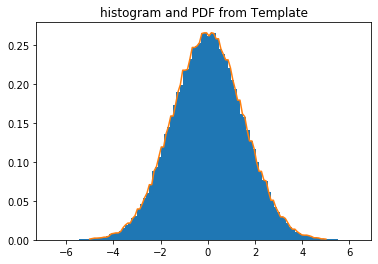

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-5.0, 5.0, 100)
plt.title("histogram and PDF from Template")
plt.hist(data, density=True, bins=100)
plt.plot(X, hist_dist.pdf(X), label='PDF')
plt.show()

Now let's also plot the CDF on top of the histogram we obtained from our data:

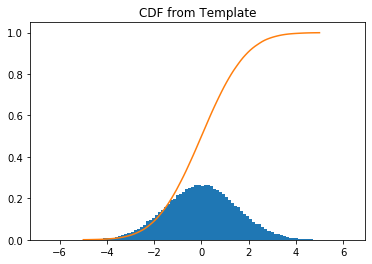

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-5.0, 5.0, 100)
plt.title("CDF from Template")
plt.hist(data, density=True, bins=100)
plt.plot(X, hist_dist.cdf(X), label='CDF')
plt.show()

Notice how the 0.5 value of the cdf is right above the mean of your histogram! We'll revisit this fact further below in the notebook, so keep this in mind.

## 2. Intuition

To really do your homework, what you need to create is a **lookup table**. The histogram gives us bins of frequency. When we generate random variates, we lookup those bins *with priority proportional to how big they are*. 

The intuition comes from genetic algorithms' (GA) roulette wheel, a.k.a. [fitness-proportionate selection](https://en.wikipedia.org/wiki/Fitness_proportionate_selection), as we will see further down.

Anyway, this is our *input* histogram:

In [12]:
hist

(array([   1,    0,    0,    1,    0,    1,    2,    3,    3,   11,    5,
           8,   12,   20,   28,   31,   35,   44,   59,   98,  106,  114,
         138,  201,  246,  277,  355,  398,  510,  594,  695,  772,  912,
        1140, 1213, 1374, 1536, 1752, 1874, 2049, 2237, 2445, 2567, 2807,
        2821, 2991, 3183, 3209, 3261, 3414, 3425, 3374, 3427, 3416, 3327,
        3159, 3072, 2979, 2846, 2647, 2492, 2311, 2087, 2038, 1819, 1636,
        1495, 1283, 1133,  990,  972,  793,  654,  539,  464,  380,  353,
         286,  217,  176,  135,  106,   81,   77,   67,   54,   34,   30,
          16,   16,   11,    6,    7,    6,    3,    0,    1,    2,    2,
           3], dtype=int64),
 array([-6.61040116, -6.48152174, -6.35264232, -6.2237629 , -6.09488348,
        -5.96600406, -5.83712464, -5.70824522, -5.5793658 , -5.45048638,
        -5.32160696, -5.19272754, -5.06384812, -4.9349687 , -4.80608928,
        -4.67720986, -4.54833044, -4.41945102, -4.2905716 , -4.16169218,
        -4.03

In [11]:
hist[0]

array([   1,    0,    0,    1,    0,    1,    2,    3,    3,   11,    5,
          8,   12,   20,   28,   31,   35,   44,   59,   98,  106,  114,
        138,  201,  246,  277,  355,  398,  510,  594,  695,  772,  912,
       1140, 1213, 1374, 1536, 1752, 1874, 2049, 2237, 2445, 2567, 2807,
       2821, 2991, 3183, 3209, 3261, 3414, 3425, 3374, 3427, 3416, 3327,
       3159, 3072, 2979, 2846, 2647, 2492, 2311, 2087, 2038, 1819, 1636,
       1495, 1283, 1133,  990,  972,  793,  654,  539,  464,  380,  353,
        286,  217,  176,  135,  106,   81,   77,   67,   54,   34,   30,
         16,   16,   11,    6,    7,    6,    3,    0,    1,    2,    2,
          3], dtype=int64)

Here is my *first cut* at the function: The idea was to create a number of workers, and to have workers work an amount of time proportional to the histogram. Then we interrupt the coroutine (by yielding) and see which worker was active:

<br />
<center>
<img src="https://media0.giphy.com/media/oDrajdEXgcAvK/source.gif" width=400 />
    Working, working, working...
</center>

And as soon as I finished writing this, I thought *this is exactly GA roulette wheel selection*! Here it is, as simple as possible:

In [16]:
hsgm = hist[0]

class Chromosome:
    def __init__(self, idx, fit):
        self.fitness = fit
        self.index = idx
        
Chromosomes = []

# this is ugly python
#i = 0
#for _ in hsgm:
#    Chromosomes.append(Chromosome(i, _))
#    i += 1

# this is pretty python
for i, _ in enumerate(hsgm):
    Chromosomes.append(Chromosome(i, _))
    
Chromosomes[9].index, Chromosomes[9].fitness 

(9, 11)

And with a little bit of experience, you *know* [np.random.choice](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) is *the* API to use:

In [17]:
def selectOne(population):
    maximum = sum([c.fitness for c in population])
    selection_probs = [c.fitness/maximum for c in population]
    return population[np.random.choice(len(population), p=selection_probs)]

In [89]:
c = selectOne(Chromosomes)
c.index, c.fitness

(29, 594)

Here is a full algorithm without "*cheating*" by using `np.random.choice`:

In [90]:
import random
import operator

def roulette_selection(weights):
    '''performs roulette wheel selection on a list, returns the index selected from the list'''

    # sort the weights in ascending order: This gives you indeces based on weights in ascending order
    sorted_indexed_weights = sorted(enumerate(weights), key=operator.itemgetter(1));
    indices, sorted_weights = zip(*sorted_indexed_weights);
    
    # calculate the cumulative probability (note that is a cdf!)
    # Essentially convert your weights to a pdf, then to a cdf
    tot_sum = sum(sorted_weights)
    prob = [x/tot_sum for x in sorted_weights]
    cum_prob = np.cumsum(prob)
    
    # now select a random a number in the range [0,1]
    random_num = random.random()

    # now go through sorted cdf, as soon as you find a bin where
    # the cdf value exceeds your random float, return the index
    # of that bin
    for index_value, cum_prob_value in zip(indices, cum_prob):
        if random_num < cum_prob_value:
            return index_value

Let's walk through this algorithm:

In [236]:
hsgm = hist[0]
sorted_indexed_weights = sorted(enumerate(hsgm), key=operator.itemgetter(1))
'; '.join(['('+str(p)+', '+str(q)+')' for (p,q) in sorted_indexed_weights])

'(1, 0); (2, 0); (4, 0); (95, 0); (0, 1); (3, 1); (5, 1); (96, 1); (6, 2); (97, 2); (98, 2); (7, 3); (8, 3); (94, 3); (99, 3); (10, 5); (91, 6); (93, 6); (92, 7); (11, 8); (9, 11); (90, 11); (12, 12); (88, 16); (89, 16); (13, 20); (14, 28); (87, 30); (15, 31); (86, 34); (16, 35); (17, 44); (85, 54); (18, 59); (84, 67); (83, 77); (82, 81); (19, 98); (20, 106); (81, 106); (21, 114); (80, 135); (22, 138); (79, 176); (23, 201); (78, 217); (24, 246); (25, 277); (77, 286); (76, 353); (26, 355); (75, 380); (27, 398); (74, 464); (28, 510); (73, 539); (29, 594); (72, 654); (30, 695); (31, 772); (71, 793); (32, 912); (70, 972); (69, 990); (68, 1133); (33, 1140); (34, 1213); (67, 1283); (35, 1374); (66, 1495); (36, 1536); (65, 1636); (37, 1752); (64, 1819); (38, 1874); (63, 2038); (39, 2049); (62, 2087); (40, 2237); (61, 2311); (41, 2445); (60, 2492); (42, 2567); (59, 2647); (43, 2807); (44, 2821); (58, 2846); (57, 2979); (45, 2991); (56, 3072); (55, 3159); (46, 3183); (47, 3209); (48, 3261); (54

In [238]:
indices, sorted_weights = zip(*sorted_indexed_weights);
', '.join([str(i) for i in indices])

'1, 2, 4, 95, 0, 3, 5, 96, 6, 97, 98, 7, 8, 94, 99, 10, 91, 93, 92, 11, 9, 90, 12, 88, 89, 13, 14, 87, 15, 86, 16, 17, 85, 18, 84, 83, 82, 19, 20, 81, 21, 80, 22, 79, 23, 78, 24, 25, 77, 76, 26, 75, 27, 74, 28, 73, 29, 72, 30, 31, 71, 32, 70, 69, 68, 33, 34, 67, 35, 66, 36, 65, 37, 64, 38, 63, 39, 62, 40, 61, 41, 60, 42, 59, 43, 44, 58, 57, 45, 56, 55, 46, 47, 48, 54, 51, 49, 53, 50, 52'

In [239]:
', '.join([str(i) for i in sorted_weights])

'0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 5, 6, 6, 7, 8, 11, 11, 12, 16, 16, 20, 28, 30, 31, 34, 35, 44, 54, 59, 67, 77, 81, 98, 106, 106, 114, 135, 138, 176, 201, 217, 246, 277, 286, 353, 355, 380, 398, 464, 510, 539, 594, 654, 695, 772, 793, 912, 972, 990, 1133, 1140, 1213, 1283, 1374, 1495, 1536, 1636, 1752, 1819, 1874, 2038, 2049, 2087, 2237, 2311, 2445, 2492, 2567, 2647, 2807, 2821, 2846, 2979, 2991, 3072, 3159, 3183, 3209, 3261, 3327, 3374, 3414, 3416, 3425, 3427'

In [241]:
tot_sum = sum(sorted_weights)
prob = [x/tot_sum for x in sorted_weights]
cum_prob = np.cumsum(prob)

In [242]:
', '.join([str(i) for i in prob])

'0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 2e-05, 3e-05, 3e-05, 3e-05, 3e-05, 5e-05, 6e-05, 6e-05, 7e-05, 8e-05, 0.00011, 0.00011, 0.00012, 0.00016, 0.00016, 0.0002, 0.00028, 0.0003, 0.00031, 0.00034, 0.00035, 0.00044, 0.00054, 0.00059, 0.00067, 0.00077, 0.00081, 0.00098, 0.00106, 0.00106, 0.00114, 0.00135, 0.00138, 0.00176, 0.00201, 0.00217, 0.00246, 0.00277, 0.00286, 0.00353, 0.00355, 0.0038, 0.00398, 0.00464, 0.0051, 0.00539, 0.00594, 0.00654, 0.00695, 0.00772, 0.00793, 0.00912, 0.00972, 0.0099, 0.01133, 0.0114, 0.01213, 0.01283, 0.01374, 0.01495, 0.01536, 0.01636, 0.01752, 0.01819, 0.01874, 0.02038, 0.02049, 0.02087, 0.02237, 0.02311, 0.02445, 0.02492, 0.02567, 0.02647, 0.02807, 0.02821, 0.02846, 0.02979, 0.02991, 0.03072, 0.03159, 0.03183, 0.03209, 0.03261, 0.03327, 0.03374, 0.03414, 0.03416, 0.03425, 0.03427'

In [245]:
', '.join([str(round(i,2)) for i in cum_prob])

'0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.04, 0.04, 0.05, 0.05, 0.06, 0.06, 0.07, 0.08, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.16, 0.17, 0.18, 0.2, 0.21, 0.23, 0.25, 0.27, 0.28, 0.3, 0.33, 0.35, 0.37, 0.39, 0.42, 0.44, 0.47, 0.49, 0.52, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.73, 0.76, 0.8, 0.83, 0.86, 0.9, 0.93, 0.97, 1.0'

Now select a random float in \[0, 1\]:

In [246]:
random_num = random.random()
random_num

0.9237501858519513

That's the level of fitness we expect for our next boyfriend/girlfriend! Who's up to the task? The first entry in the list above which is bigger than that level of fitness! 

This is the same thing as spinning a roulette wheel and seeing which piece of the pie it lands on.

<br />
<center>
<img src="https://www.researchgate.net/publication/311245613/figure/fig3/AS:566020097220608@1511961115040/Roulette-wheel-selection-based-on-fitness.png" width=400 />
</center>

What is the expectation for your random number? 0.5, right? You can see that 0.5 lands you right next to the "*big*" bins, the ones with big fitness values.

In [132]:
len(hsgm)

100

In [185]:
roulette_selection(hsgm)

51

The input to your homework function is a histogram $h$ (with any number of bins), a range $r$ to generate values from, and the number $n$ of desired random variates.

Let's break down the input interval into *as many intervals as there are bins in the input histogram*. Then we use roulette wheel selection to pick one of these bins. Then we generate a random float within the interval of that bin, and that is our first random variate!

In [186]:
# inputs
h = hsgm
r = range(-23, 23)
n = 10000

# we build
x = np.linspace(r.start, r.stop, len(hsgm))
x[0], x[len(hsgm)//2], x[len(hsgm)-1]

(-23.0, 0.23232323232323182, 23.0)

In [193]:
i = roulette_selection(h)
print(i)
if i == len(hsgm) - 1: i -= 1
x[i], x[i+1]

36


(-6.272727272727273, -5.80808080808081)

In [194]:
random.uniform(x[i], x[i+1])

-5.825709817572215

ready?

In [196]:
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))

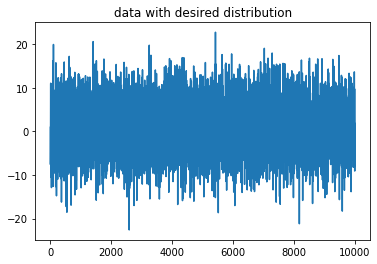

In [197]:
plt.title("data with desired distribution")
plt.plot(my_random_variates, label='data')
plt.show()

In [198]:
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

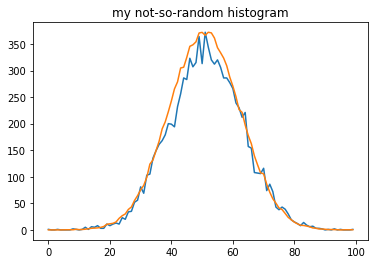

In [201]:
plt.title("my not-so-random histogram")
plt.plot(my_not_so_random_histogram[0], label='histogram')
plt.plot(hsgm * max(my_not_so_random_histogram[0]) / max(hsgm), label='original histogram')
plt.show()

And... what if we generate ten times more datapoints, say 100,000?

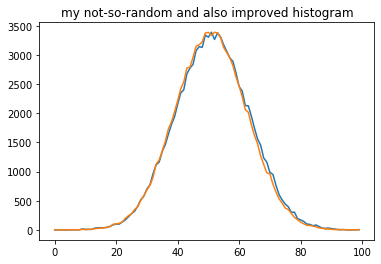

In [206]:
my_random_variates = []
for _ in range(n * 10):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
    
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

plt.title("my not-so-random and also improved histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(hsgm * max(my_not_so_random_histogram[0]) / max(hsgm), label='original histogram')
plt.show()

Getting closer and closer the more random variates I produce! This is the key to *frequentist statistics*. If i have tons of data, then I'm in good shape. However, *when we don't have enough data*, which is the *sweet spot( of state of the art ML, that is when we turn to *Bayesian statistics*!

## Yang Huang's function

This is a student's function, who wondered why we had to do roulette wheel selection:

In [ ]:
import random
## This function takes a histogram 'A'(tuple), size of fakedata 'N'(int) and the range of fakedata 'R' (tuple) as input
def fakeData(A, N, R):
    nOfBins = A[0].size
    sum = 0
    for _ in A[0]:
        sum +=_
    ## n is the size of original dataset
    n = sum 
    
    ## set the frequency in fake dataset
    frequency = []
    for i in range(nOfBins):
        frequency.append(A[0][i]/n*N)
        
    ## set the width of bins in new dataset
    w = (R[1]-R[0])/nOfBins
    
    ## set ranges for new bins
    ranges = []
    for i in range(nOfBins+1):
        ranges.append(R[0] + i*w)
        
    ## create fakedata   
    data = []
    #this is beautiful python
    for m, i in enumerate(frequency):
        for _ in range(int(i)):
            data.append(random.uniform(ranges[m],ranges[m+1]))
    
    return data          

Let's examine what Yang's function does:

In [251]:
hist[0]

array([   1,    0,    0,    1,    0,    1,    2,    3,    3,   11,    5,
          8,   12,   20,   28,   31,   35,   44,   59,   98,  106,  114,
        138,  201,  246,  277,  355,  398,  510,  594,  695,  772,  912,
       1140, 1213, 1374, 1536, 1752, 1874, 2049, 2237, 2445, 2567, 2807,
       2821, 2991, 3183, 3209, 3261, 3414, 3425, 3374, 3427, 3416, 3327,
       3159, 3072, 2979, 2846, 2647, 2492, 2311, 2087, 2038, 1819, 1636,
       1495, 1283, 1133,  990,  972,  793,  654,  539,  464,  380,  353,
        286,  217,  176,  135,  106,   81,   77,   67,   54,   34,   30,
         16,   16,   11,    6,    7,    6,    3,    0,    1,    2,    2,
          3], dtype=int64)

In [253]:
N = 10000
R = [-23, 23]
nOfBins = hist[0].size
sum = 0
for _ in hist[0]:
    sum +=_
## n is the size of original dataset
n = sum 
n

100000

>**CORRECTION**: n is the **cumsum** (or cumulative sum) of the histogram, ***not*** the size of of the dataset, which is `len(hist[0]) = 100`

In [250]:
frequency = []
for i in range(nOfBins):
    frequency.append(hist[0][i]/n*N)
frequency

[0.1,
 0.0,
 0.0,
 0.1,
 0.0,
 0.1,
 0.2,
 0.3,
 0.3,
 1.1,
 0.5,
 0.8,
 1.2,
 2.0,
 2.8,
 3.1,
 3.5,
 4.4,
 5.9,
 9.799999999999999,
 10.6,
 11.4,
 13.799999999999999,
 20.1,
 24.599999999999998,
 27.7,
 35.5,
 39.8,
 51.00000000000001,
 59.4,
 69.5,
 77.2,
 91.2,
 114.0,
 121.3,
 137.4,
 153.6,
 175.20000000000002,
 187.4,
 204.9,
 223.70000000000002,
 244.5,
 256.7,
 280.7,
 282.09999999999997,
 299.09999999999997,
 318.29999999999995,
 320.9,
 326.1,
 341.4,
 342.5,
 337.4,
 342.70000000000005,
 341.6,
 332.7,
 315.9,
 307.2,
 297.9,
 284.59999999999997,
 264.7,
 249.20000000000002,
 231.1,
 208.7,
 203.79999999999998,
 181.9,
 163.6,
 149.5,
 128.29999999999998,
 113.3,
 99.00000000000001,
 97.19999999999999,
 79.3,
 65.39999999999999,
 53.9,
 46.4,
 38.0,
 35.300000000000004,
 28.6,
 21.7,
 17.6,
 13.5,
 10.6,
 8.1,
 7.699999999999999,
 6.7,
 5.4,
 3.4000000000000004,
 2.9999999999999996,
 1.6,
 1.6,
 1.1,
 0.6,
 0.7,
 0.6,
 0.3,
 0.0,
 0.1,
 0.2,
 0.2,
 0.3]

So it appears `frequency` is just a *rescaled* histogram.

In [254]:
## set the width of bins in new dataset
w = (R[1]-R[0])/nOfBins
w

0.46

So we will generate values from intervals of size `w` above, with frequency proportional to the size of the corresponding histogram bin! So far, so good!

In [255]:
## set ranges for new bins
ranges = []
for i in range(nOfBins+1):
    ranges.append(R[0] + i*w)
ranges

[-23.0,
 -22.54,
 -22.08,
 -21.62,
 -21.16,
 -20.7,
 -20.24,
 -19.78,
 -19.32,
 -18.86,
 -18.4,
 -17.939999999999998,
 -17.48,
 -17.02,
 -16.56,
 -16.1,
 -15.64,
 -15.18,
 -14.719999999999999,
 -14.26,
 -13.799999999999999,
 -13.34,
 -12.879999999999999,
 -12.42,
 -11.959999999999999,
 -11.5,
 -11.04,
 -10.58,
 -10.12,
 -9.66,
 -9.2,
 -8.74,
 -8.28,
 -7.8199999999999985,
 -7.359999999999999,
 -6.899999999999999,
 -6.439999999999998,
 -5.98,
 -5.52,
 -5.059999999999999,
 -4.599999999999998,
 -4.140000000000001,
 -3.6799999999999997,
 -3.219999999999999,
 -2.759999999999998,
 -2.3000000000000007,
 -1.8399999999999999,
 -1.379999999999999,
 -0.9199999999999982,
 -0.4599999999999973,
 0.0,
 0.46000000000000085,
 0.9200000000000017,
 1.3800000000000026,
 1.8399999999999999,
 2.3000000000000007,
 2.7600000000000016,
 3.2200000000000024,
 3.6799999999999997,
 4.140000000000001,
 4.600000000000001,
 5.060000000000002,
 5.52,
 5.98,
 6.440000000000001,
 6.900000000000002,
 7.360000000000003,
 7

And those are the intervals we will generate values from. Grrrrrrrrrrrreat!

In [256]:
## create fakedata   
data = []
#this is beautiful python
for m, i in enumerate(frequency):
    for _ in range(int(i)):
        data.append(random.uniform(ranges[m],ranges[m+1]))
data

[-18.547898831290432,
 -17.429307659682415,
 -16.839007585319436,
 -16.963644132708076,
 -16.36968543953011,
 -16.30222536526194,
 -15.813336958550812,
 -15.846996644191353,
 -16.091754431802663,
 -15.533075344062059,
 -15.327773302839956,
 -15.535973394483133,
 -14.994716372181326,
 -15.075492857140016,
 -15.125359594905126,
 -15.038895663820822,
 -14.607031386691384,
 -14.472075340113049,
 -14.262220170533215,
 -14.43268029650638,
 -14.567553629211938,
 -13.871830041587208,
 -14.089192636434412,
 -13.926178508809155,
 -14.195321787719516,
 -13.805816221951059,
 -13.976111478806404,
 -14.025062279997371,
 -13.959842480397088,
 -14.089462314130495,
 -13.784529055575447,
 -13.428493679756295,
 -13.62322372164034,
 -13.439533170781365,
 -13.554798494042355,
 -13.3873060277677,
 -13.780835174889571,
 -13.744178421197317,
 -13.563578118053137,
 -13.77387717423846,
 -13.07923967675003,
 -13.123542461122483,
 -13.07781998220532,
 -13.136880692753435,
 -13.294965579040934,
 -12.89272666072383

`for m, i in enumerate(frequency):` essentially goes through the original histogram and gets the bin index `m` and the bin count `i`.

In that outer loop. `for _ in range(int(i)):` ranges the bin count. So it's a much larger range of numbers for big bins (bins with big values), and a much smaller range of numbers for small bins. In other words, what happens under the `for` loop will happen ***more often*** when we're visiting big bins than when we're visiting small bins. In other words, this is **roulette wheel selection**.

In that inner loop, `random.uniform(ranges[m],ranges[m+1])` selects a single random number, with uniform probability between `ranges[m]` and `ranges[m+1]`:

In [258]:
print(ranges[10],ranges[11])
random.uniform(ranges[10],ranges[11])

-18.4 -17.939999999999998


-17.97052244100264

Finally, `data.append` appends the value to our list of generated numbers.

<br />
<center>
<img src="https://media1.giphy.com/media/9xuUhwozi3qvJdPogI/giphy.gif" width=400 />
</center>

## 3. Random variates from histogram

Ok, we wrote the *prototype*, but now we're ready to write a general class that leverages key probability concepts such as **pdf** and **cdf**, does some unit testing, etc.

The following class will generate random variates, given a histogram. Note how I reduced tab spaces, long notebook cells are prettier that way.

In [210]:
import pylab
import numpy

class GeneralRandom:
  """This class enables us to generate random numbers with an arbitrary 
  distribution."""
  
  def __init__(self, x = pylab.arange(-1.0, 1.0, .01), p = None, Nrl = 1000):
    """Initialize the lookup table (with default values if necessary)
    Inputs:
    x = random number values
    p = probability density profile at that point
    Nrl = number of reverse look up values between 0 and 1"""  
    
    if not isinstance(p, numpy.ndarray):
        if not isinstance(p, tuple):
            if p == None:
                p = pylab.exp(-10*x**2.0)
    self.set_pdf(x, p, Nrl)
   

  def set_pdf(self, x, p, Nrl = 1000):
    """Generate the lookup tables. 
    x is the value of the random variate
    pdf is its probability density
    cdf is the cumulative pdf
    inversecdf is the inverse look up table"""
    
    self.x = x
    if isinstance(p, tuple):
        self.pdf = p/sum(p) #normalize it
    else:
        self.pdf = p/p.sum() #normalize it
        
    self.cdf = self.pdf.cumsum()
    self.inversecdfbins = Nrl
    self.Nrl = Nrl
    
    y = pylab.arange(Nrl)/float(Nrl)
    delta = 1.0/Nrl
    self.inversecdf = pylab.zeros(Nrl)    
    self.inversecdf[0] = self.x[0]
    cdf_idx = 0
    
    for n in range(1,self.inversecdfbins):
        while self.cdf[cdf_idx] < y[n] and cdf_idx < Nrl:
            cdf_idx += 1
        self.inversecdf[n] = self.x[cdf_idx-1] + (
            self.x[cdf_idx] - self.x[cdf_idx-1]) * (y[n] - self.cdf[cdf_idx-1])/(self.cdf[cdf_idx] - self.cdf[cdf_idx-1]) 
        if cdf_idx >= Nrl:
            break
    self.delta_inversecdf = pylab.concatenate((pylab.diff(self.inversecdf), [0]))
              
  def random(self, N = 1000):
    """Give us N random numbers with the requested distribution"""

    idx_f = numpy.random.uniform(size = N, high = self.Nrl-1)
    idx = pylab.array([idx_f],'i')
    y = self.inversecdf[idx] + (idx_f - idx)*self.delta_inversecdf[idx]

    return y
  
  def plot_pdf(self):
    pylab.plot(self.x, self.pdf)
    
  def self_test(self, N = 1000):
    pylab.figure()
    #The cdf
    pylab.subplot(2,2,1)
    pylab.plot(self.x, self.cdf)
    #The inverse cdf
    pylab.subplot(2,2,2)
    y = pylab.arange(self.Nrl)/float(self.Nrl)
    pylab.plot(y, self.inversecdf)
    
    #The actual generated numbers
    pylab.subplot(2,2,3)
    y = self.random(N)
    p1, edges = pylab.histogram(y, bins = 50, 
                                range = (self.x.min(), self.x.max()), 
                                normed = True)
    x1 = 0.5*(edges[0:-1] + edges[1:])
    pylab.plot(x1, p1/p1.max())
    pylab.plot(self.x, self.pdf/self.pdf.max())

d:\Anaconda3.5.1\envs\tf-vision\lib\site-packages\ipykernel_launcher.py:81: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


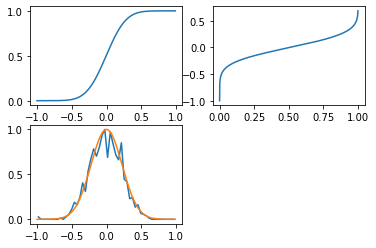

In [211]:
test = GeneralRandom()
test.self_test()

In [13]:
x = pylab.arange(-1.0, 1.0, .01)
pylab.exp(-10*x**2.0)

array([4.53999298e-05, 5.53961755e-05, 6.74583627e-05, 8.19828893e-05,
       9.94356357e-05, 1.20362805e-04, 1.45403198e-04, 1.75302063e-04,
       2.10926674e-04, 2.53283790e-04, 3.03539138e-04, 3.63039106e-04,
       4.33334765e-04, 5.16208399e-04, 6.13702669e-04, 7.28152539e-04,
       8.62220086e-04, 1.01893226e-03, 1.20172170e-03, 1.41447053e-03,
       1.66155727e-03, 1.94790664e-03, 2.27904223e-03, 2.66114180e-03,
       3.10109501e-03, 3.60656314e-03, 4.18604042e-03, 4.84891651e-03,
       5.60553935e-03, 6.46727781e-03, 7.44658307e-03, 8.55704807e-03,
       9.81346359e-03, 1.12318701e-02, 1.28296036e-02, 1.46253347e-02,
       1.66390989e-02, 1.88923160e-02, 2.14077987e-02, 2.42097460e-02,
       2.73237224e-02, 3.07766190e-02, 3.45965954e-02, 3.88130014e-02,
       4.34562758e-02, 4.85578213e-02, 5.41498541e-02, 6.02652275e-02,
       6.69372276e-02, 7.41993418e-02, 8.20849986e-02, 9.06272807e-02,
       9.98586094e-02, 1.09810404e-01, 1.20512717e-01, 1.31993843e-01,
      

In [14]:
type(data)

numpy.ndarray

In [15]:
data

array([-1.6284459 ,  1.49601817,  0.42446775, ...,  1.73824966,
        3.42561844, -1.97740727])

This is our histogram from above: generated through random variates of a normal distribution:

In [17]:
hist[0]

array([   1,    0,    0,    1,    0,    1,    2,    3,    3,   11,    5,
          8,   12,   20,   28,   31,   35,   44,   59,   98,  106,  114,
        138,  201,  246,  277,  355,  398,  510,  594,  695,  772,  912,
       1140, 1213, 1374, 1536, 1752, 1874, 2049, 2237, 2445, 2567, 2807,
       2821, 2991, 3183, 3209, 3261, 3414, 3425, 3374, 3427, 3416, 3327,
       3159, 3072, 2979, 2846, 2647, 2492, 2311, 2087, 2038, 1819, 1636,
       1495, 1283, 1133,  990,  972,  793,  654,  539,  464,  380,  353,
        286,  217,  176,  135,  106,   81,   77,   67,   54,   34,   30,
         16,   16,   11,    6,    7,    6,    3,    0,    1,    2,    2,
          3], dtype=int64)

In [18]:
type(hist_dist)

scipy.stats._continuous_distns.rv_histogram

In [19]:
hist_dist

So we have a histogram. Let's instantiate the class from that histogram in order to generate simulated data.

d:\Anaconda3.5.1\envs\tf-vision\lib\site-packages\ipykernel_launcher.py:77: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


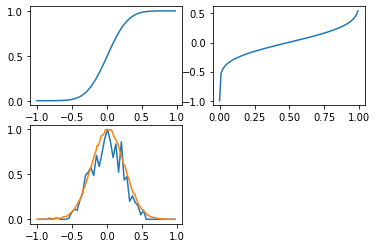

In [20]:
rvs_from_hist = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = hist[0], Nrl = 100)
rvs_from_hist.self_test()

Now let's generate random variates:

In [21]:
sim_data = rvs_from_hist.random()
sim_data

array([[ 1.88779542e-01,  2.77499450e-02, -4.29954141e-01,
         1.27274368e-01, -8.24461874e-02, -1.19627873e-01,
         2.30273563e-01,  6.34398472e-02, -2.86119819e-01,
        -2.57262967e-01,  1.36133147e-01,  3.75458993e-01,
         5.35547775e-02,  7.41289765e-03,  4.87382933e-02,
         3.51404769e-02, -2.61122233e-01, -3.49890874e-01,
        -1.98433232e-01, -4.22519972e-01,  1.93085611e-01,
         1.98127137e-01, -5.07765030e-02,  4.80550299e-02,
         2.73091226e-01,  3.09038053e-02,  1.74793252e-01,
         2.47400009e-02, -1.64215814e-01, -4.67413260e-01,
         1.25632454e-01, -2.25400966e-01, -3.11526928e-01,
         1.36431325e-01, -1.93027395e-01, -1.38143552e-01,
         1.56609424e-01,  1.87009654e-01, -1.45650185e-01,
        -5.74290708e-02,  1.23343281e-02,  5.09672527e-01,
        -1.64345084e-01, -8.52376654e-02,  2.05630550e-01,
        -2.03428046e-01,  2.77914111e-02, -3.25960745e-01,
         3.40818889e-01, -2.40746110e-01, -3.06384239e-0

In [22]:
sim_data[0]

array([ 1.88779542e-01,  2.77499450e-02, -4.29954141e-01,  1.27274368e-01,
       -8.24461874e-02, -1.19627873e-01,  2.30273563e-01,  6.34398472e-02,
       -2.86119819e-01, -2.57262967e-01,  1.36133147e-01,  3.75458993e-01,
        5.35547775e-02,  7.41289765e-03,  4.87382933e-02,  3.51404769e-02,
       -2.61122233e-01, -3.49890874e-01, -1.98433232e-01, -4.22519972e-01,
        1.93085611e-01,  1.98127137e-01, -5.07765030e-02,  4.80550299e-02,
        2.73091226e-01,  3.09038053e-02,  1.74793252e-01,  2.47400009e-02,
       -1.64215814e-01, -4.67413260e-01,  1.25632454e-01, -2.25400966e-01,
       -3.11526928e-01,  1.36431325e-01, -1.93027395e-01, -1.38143552e-01,
        1.56609424e-01,  1.87009654e-01, -1.45650185e-01, -5.74290708e-02,
        1.23343281e-02,  5.09672527e-01, -1.64345084e-01, -8.52376654e-02,
        2.05630550e-01, -2.03428046e-01,  2.77914111e-02, -3.25960745e-01,
        3.40818889e-01, -2.40746110e-01, -3.06384239e-03,  1.47192032e-01,
        4.73690232e-02,  

In [60]:
len(sim_data[0])

1000

What does the data look like?

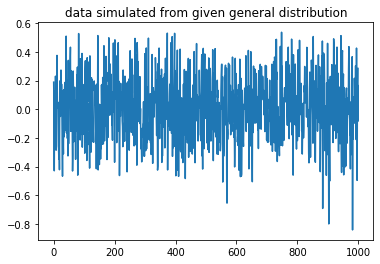

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("data simulated from given general distribution")
plt.plot(sim_data[0], label='sim_data')
plt.show()

Let's evaluate the histogram from the data, and also use `scipy.stats.rv_histogram` to generate random variates from that histogram:

In [24]:
hist2 = np.histogram(sim_data, bins=100)
hist2_dist = scipy.stats.rv_histogram(hist2)

Let's plot the histogram of the random variates on top of the pdf from random variates from of the histogram of the random variates:

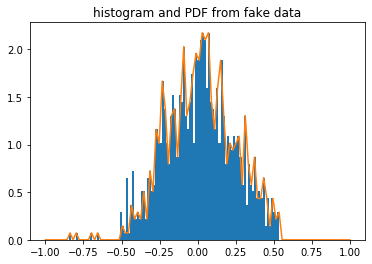

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-1.0, 1.0, 100)
plt.title("histogram and PDF from fake data")
plt.hist(sim_data[0], density=True, bins=100)
plt.plot(X, hist2_dist.pdf(X), label='PDF')
plt.show()

Let's do it again. Now we use the histogram above as the input to our class.

d:\Anaconda3.5.1\envs\tf-vision\lib\site-packages\ipykernel_launcher.py:77: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


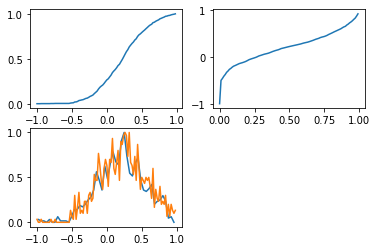

In [25]:
rvs_from_hist2 = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = hist2[0], Nrl = 100)
rvs_from_hist2.self_test()

In [26]:
sim_data2 = rvs_from_hist2.random()
sim_data2

array([[-0.13412145,  0.56390999, -0.11577578,  0.72787012,  0.20835459,
        -0.08640261,  0.06044592,  0.09883082,  0.60598603, -0.04284978,
         0.82757056,  0.19470471,  0.18402918,  0.83300684,  0.3843985 ,
         0.52709435,  0.15428754, -0.03291071,  0.18975103,  0.0802169 ,
         0.28870467,  0.51754654, -0.02340463,  0.51720628,  0.05939616,
         0.26541343,  0.70902492, -0.43964683, -0.00818717,  0.71385177,
        -0.14171791,  0.42723611,  0.00601519,  0.80389315,  0.22368103,
         0.5796287 ,  0.3230803 , -0.12102611, -0.46188756,  0.35213893,
         0.57983252,  0.04596815,  0.56348222,  0.52353371,  0.11594495,
         0.59993041,  0.92085287,  0.76393267,  0.63388728,  0.12303777,
         0.25263172, -0.0602188 ,  0.65301888,  0.13299645,  0.16133696,
        -0.12495567, -0.11155539,  0.49224117,  0.21480985,  0.43221415,
         0.59088975, -0.23373874, -0.229682  ,  0.54565162,  0.43258697,
        -0.80948263, -0.64846472,  0.07141131, -0.1

Notice how the histograms degenerate in shape as we continue the process of generating numbers from a histogram, then using the generated numbers to get the new histogram, and using that as input to the same process.

In [27]:
hist3 = np.histogram(sim_data2, bins=100)
hist3_dist = scipy.stats.rv_histogram(hist3)

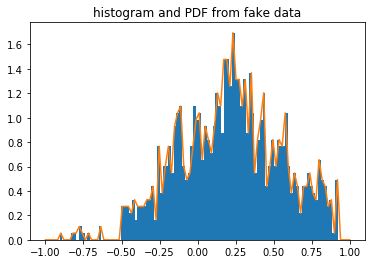

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-1.0, 1.0, 100)
plt.title("histogram and PDF from fake data")
plt.hist(sim_data2[0], density=True, bins=100)
plt.plot(X, hist3_dist.pdf(X), label='PDF')
plt.show()

## 4. Empirical data

Now, we'll use empirical rather than simulated data: Tennesse rainfall.

In [212]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

In [213]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


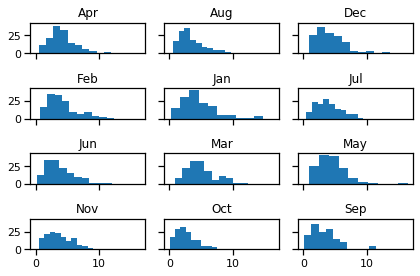

In [214]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

In [215]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)

This is precipitation for the month of April and its histogram:

In [216]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

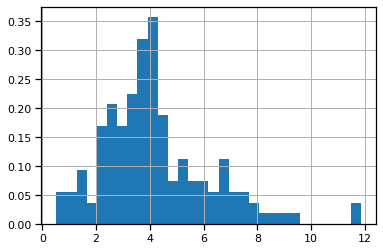

In [222]:
april_h = precip.Apr.hist(normed=True, bins=30)

In [218]:
precip.Apr.values

array([ 4.13,  5.91,  3.59, 11.84,  4.22,  3.62,  9.47,  6.88,  2.88,
        5.26,  5.12,  3.59,  9.12,  3.51,  3.75,  2.36,  2.67,  4.18,
        2.83,  3.84,  2.24,  7.45,  4.11,  4.05,  3.07,  2.92,  5.79,
        3.16,  3.25,  4.04,  4.99,  3.08,  4.  ,  2.35,  1.5 ,  1.75,
        4.66,  4.43,  4.12,  6.1 ,  5.11, 11.73,  1.65,  3.83,  0.72,
        2.49,  4.05,  3.39,  2.66,  8.58,  3.5 ,  4.53,  4.26,  3.55,
        3.74,  2.45,  7.38,  3.22,  3.93,  1.16,  2.44,  7.2 ,  4.17,
        2.24,  4.51,  3.7 ,  3.73,  2.23,  3.96,  5.24,  2.4 ,  4.22,
        2.97,  3.85,  5.51,  3.45,  3.56,  1.15,  5.27,  1.58,  4.75,
        2.01,  4.53,  4.42,  4.62,  4.23,  2.79,  6.35,  2.49,  2.04,
        4.5 ,  6.91,  3.37,  5.86,  5.72,  5.08,  3.4 ,  3.57,  6.03,
        6.81,  3.34,  3.58,  7.  ,  3.97,  3.55,  1.53,  7.87,  2.42,
        7.8 ,  3.67,  4.78,  4.36,  6.8 ,  8.41,  2.91,  0.52,  1.03,
        2.09,  2.68,  1.6 ,  3.35,  0.77,  3.33,  5.72,  3.95,  3.68,
        2.42,  6.31,

In [223]:
wx_hist = np.histogram(precip.Apr.values, bins=100)
wx_hist

(array([1, 1, 1, 0, 1, 2, 0, 0, 2, 3, 1, 0, 0, 3, 0, 4, 7, 3, 2, 2, 3, 3,
        2, 2, 3, 5, 7, 6, 4, 3, 5, 8, 5, 3, 2, 4, 3, 2, 0, 1, 3, 3, 0, 0,
        1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 0, 2, 1, 2, 0, 0, 2, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int64),
 array([ 0.52  ,  0.6332,  0.7464,  0.8596,  0.9728,  1.086 ,  1.1992,
         1.3124,  1.4256,  1.5388,  1.652 ,  1.7652,  1.8784,  1.9916,
         2.1048,  2.218 ,  2.3312,  2.4444,  2.5576,  2.6708,  2.784 ,
         2.8972,  3.0104,  3.1236,  3.2368,  3.35  ,  3.4632,  3.5764,
         3.6896,  3.8028,  3.916 ,  4.0292,  4.1424,  4.2556,  4.3688,
         4.482 ,  4.5952,  4.7084,  4.8216,  4.9348,  5.048 ,  5.1612,
         5.2744,  5.3876,  5.5008,  5.614 ,  5.7272,  5.8404,  5.9536,
         6.0668,  6.18  ,  6.2932,  6.4064,  6.5196,  6.6328,  6.746 ,
         6.8592,  6.9724,  7.0856,  7.1988,  7.312 ,  7.4252,  7.5384,
      

In [224]:
wx_hist[0]

array([1, 1, 1, 0, 1, 2, 0, 0, 2, 3, 1, 0, 0, 3, 0, 4, 7, 3, 2, 2, 3, 3,
       2, 2, 3, 5, 7, 6, 4, 3, 5, 8, 5, 3, 2, 4, 3, 2, 0, 1, 3, 3, 0, 0,
       1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 0, 2, 1, 2, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int64)

Let's use the histogram from precipitation for the month of April as input. First, we'll do it with our prototype, then with the general class we wrote:

In [225]:
precip.Apr.values.min()

0.52

In [226]:
precip.Apr.values.max()

11.84

In [227]:
# inputs
h = wx_hist[0]
r = (precip.Apr.values.min(), precip.Apr.values.max())
n = 10000

# we build
x = np.linspace(r[0], r[1], len(h))
x[0], x[len(h)//2], x[len(h)-1]

(0.52, 6.237171717171718, 11.84)

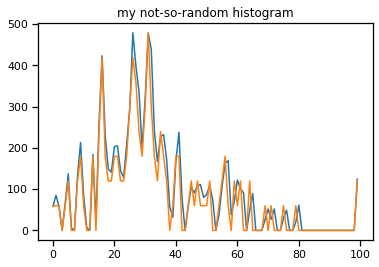

In [228]:
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    if i == len(h) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
    
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(h))

plt.title("my not-so-random histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(my_not_so_random_histogram[0].max() / h.max() * h, label='original histogram')
plt.show()

</br >
<center>
<img src="https://media3.giphy.com/media/7NOL7wCK1ddCQTiv51/giphy.gif" width=400 />
</center>

Now let's use the class:

d:\Anaconda3.5.1\envs\tf-vision\lib\site-packages\ipykernel_launcher.py:77: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


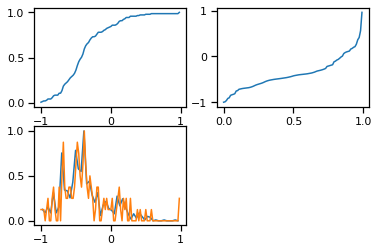

In [48]:
wx_from_hist = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = wx_hist[0], Nrl = 100)
wx_from_hist.self_test()

Let's generate random precipitation values from the month of April that abide by that histogram:

In [49]:
wx_sim_data = wx_from_hist.random()
wx_sim_data

array([[-2.02800510e-01, -1.14991311e-01, -7.03707394e-01,
        -5.52896326e-01, -4.81031122e-01, -4.58795905e-01,
        -2.60870604e-01, -4.67768689e-01, -6.62743418e-01,
         1.15111297e-01, -4.82619934e-01, -7.04541053e-01,
         2.11120465e-01,  2.11772634e-01, -4.85284851e-01,
         1.31659826e-01,  3.35010694e-01, -4.79889350e-01,
         8.57076757e-02, -3.19223303e-01, -6.97438759e-01,
        -3.56857192e-01, -6.81040055e-01,  3.68304194e-01,
        -6.94872831e-01, -9.24384088e-02, -3.99826950e-01,
        -4.13619969e-01, -3.65307143e-01, -8.41173665e-01,
         9.99545479e-02, -4.70120902e-01, -6.91896945e-01,
         1.93169803e-01, -4.88254626e-01, -6.73551132e-01,
         4.02150931e-01, -3.07928259e-01, -4.73429604e-01,
        -5.93011661e-01,  2.49967875e-01, -2.85235445e-01,
        -3.21784848e-01, -1.80798676e-01, -4.85906429e-02,
        -5.60779065e-02, -5.12474300e-01, -3.25856600e-01,
        -4.73678587e-01,  1.75250022e-01, -4.70330752e-0

In [50]:
wx_sim_data[0]

array([-2.02800510e-01, -1.14991311e-01, -7.03707394e-01, -5.52896326e-01,
       -4.81031122e-01, -4.58795905e-01, -2.60870604e-01, -4.67768689e-01,
       -6.62743418e-01,  1.15111297e-01, -4.82619934e-01, -7.04541053e-01,
        2.11120465e-01,  2.11772634e-01, -4.85284851e-01,  1.31659826e-01,
        3.35010694e-01, -4.79889350e-01,  8.57076757e-02, -3.19223303e-01,
       -6.97438759e-01, -3.56857192e-01, -6.81040055e-01,  3.68304194e-01,
       -6.94872831e-01, -9.24384088e-02, -3.99826950e-01, -4.13619969e-01,
       -3.65307143e-01, -8.41173665e-01,  9.99545479e-02, -4.70120902e-01,
       -6.91896945e-01,  1.93169803e-01, -4.88254626e-01, -6.73551132e-01,
        4.02150931e-01, -3.07928259e-01, -4.73429604e-01, -5.93011661e-01,
        2.49967875e-01, -2.85235445e-01, -3.21784848e-01, -1.80798676e-01,
       -4.85906429e-02, -5.60779065e-02, -5.12474300e-01, -3.25856600e-01,
       -4.73678587e-01,  1.75250022e-01, -4.70330752e-01, -3.80515549e-01,
        1.61280458e-01, -

Let's plot the histogram of these fake precipitation values:

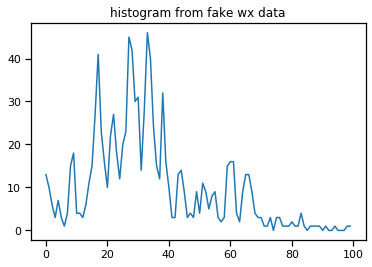

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("histogram from fake wx data")
plt.plot(np.histogram(wx_sim_data[0], bins=100)[0], label='histogram')
plt.show()

Does the histogram from the fake precipitation values look like Tennessee's real April histogram?

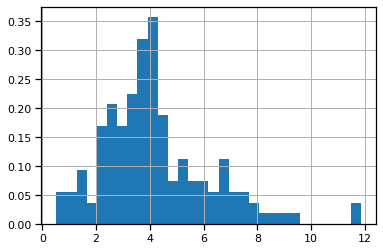

In [49]:
april_h = precip.Apr.hist(normed=True, bins=30)

# Conclusion

Math is by far the best model, since functions give us the *lowest possible model dimensionality reduction*. But when the math is too tough, you can always pick a *program*. The number of SLOC in the program will be much bigger than the number of parameters in your analytic function, but if your model *rocks*, like the one in this notebook, then use it!